In [1]:
%matplotlib inline
import scipy.io
import scipy.io.wavfile
import sounddevice as sd
import numpy as np
import soundfile as sf

import matplotlib.pyplot as plt

In [2]:
complete_mixture_length_in_s = 673194 / 16000
complete_mixture_length_in_s

42.074625

In [3]:
def play_from_filepath(fp, name='mixture', framerate=16000, start_in_s=0):
    sound = scipy.io.loadmat(fp)
    print('mixture shape: ' + (str(sound['earSout'].shape)))
    play_from_array(sound['earSout'], name, framerate, start_in_s=start_in_s)
    
    
def play_from_array(sound, name, framerate, start_in_s=0):
    start_frame = int(start_in_s * framerate)
    sound_arr = sound[start_frame:]
    # somehow try to invert the second axis - may resolve the feeling that the events happen on the left side
    #sound_arr = np.swapaxes(np.swapaxes(sound_arr, 0, sound_arr)[::-1], 0, 1)
    sf.write('demo_sound_{}_start{}s.wav'.format(name, str(start_in_s)), sound_arr, framerate)
    sd.play(sound_arr, framerate)

In [4]:
# master
fp = "/Users/Heiner/repos/binaural_audition/common/data/data_creation/generalSoundsNI.phone.TelephoneElectron+6037_36_3.wav.mat"
play_from_filepath(fp, 'mixture_TelephoneElectron+6037_36_3', start_in_s=25)

mixture shape: (673194, 2)


In [5]:
sd.stop()

In [43]:
SNR_MASTER = 0
SNR_DISTRACTOR1 = -20
SNR_DISTRACTOR2 = 12

def SNR_RATES(SNR_MASTER, SNR_DISTRACTOR1, SNR_DISTRACTOR2, SNR_DEVIATION_RATE = 0.9):
    SNR_BIGGEST = max(SNR_MASTER, SNR_DISTRACTOR1, SNR_DISTRACTOR2)
    SNR_SMALLEST = min(SNR_MASTER, SNR_DISTRACTOR1, SNR_DISTRACTOR2)
    SNR_DIFF = SNR_BIGGEST - SNR_SMALLEST

    SNR_MASTER *= SNR_DEVIATION_RATE
    SNR_DISTRACTOR1 *= SNR_DEVIATION_RATE
    SNR_DISTRACTOR2 *= SNR_DEVIATION_RATE
    
    if SNR_SMALLEST < 0:
        SNR_ADD = abs(SNR_SMALLEST)
        SNR_MASTER += SNR_ADD
        SNR_DISTRACTOR1 += SNR_ADD
        SNR_DISTRACTOR2 += SNR_ADD
    SNR_MASTER_RATE = SNR_MASTER / SNR_DIFF
    SNR_DISTRACTOR1_RATE = SNR_DISTRACTOR1 / SNR_DIFF
    SNR_DISTRACTOR2_RATE = SNR_DISTRACTOR2 / SNR_DIFF
    return SNR_MASTER_RATE, SNR_DISTRACTOR1_RATE, SNR_DISTRACTOR2_RATE

SNR_MASTER_RATE, SNR_DISTRACTOR1_RATE, SNR_DISTRACTOR2_RATE = SNR_RATES(SNR_MASTER, SNR_DISTRACTOR1, SNR_DISTRACTOR2)

In [7]:
# distractor 1

fp = '/Users/Heiner/repos/binaural_audition/common/data/data_creation/distractor1_no2_CloseOutsideMic2.wav'
array, framerate = sf.read(fp) 
play_from_array(array, 'distractor1_no2', framerate, start_in_s=25-1.9219)
sd.stop()

fp = '/Users/Heiner/repos/binaural_audition/common/data/data_creation/distractor1_no3_BAG-PAPER_GEN-HDF-02778.wav'
onset = 32.850875
framerate, array = scipy.io.wavfile.read(fp)
play_from_array(array, 'distractor1_no3', framerate, start_in_s=0)
sd.stop()

fp = '/Users/Heiner/repos/binaural_audition/common/data/data_creation/distractor1_no4_ScissorPaper_DIGIF5-88.wav'
onset = 38.6094375
framerate, array = scipy.io.wavfile.read(fp)
time_sound = int((complete_mixture_length_in_s - onset) * framerate)
array = array[:time_sound, :]
play_from_array(array, 'distractor1_no4', framerate, start_in_s=0)
sd.stop()

# distractor 2

fp = '/Users/Heiner/repos/binaural_audition/common/data/data_creation/distractor2_no3_CartoonFootsteps+4003_46_1.wav'
onset = 12.0458125
framerate, array = scipy.io.wavfile.read(fp)
time_sound = int((complete_mixture_length_in_s - onset) * framerate)
array = array[:time_sound, :]
play_from_array(array, 'distractor2_no3', framerate, start_in_s=25-12.0458)
sd.stop()

/Users/Heiner/anaconda3/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [59]:
def plot_from_array(sound, name, framerate, start_in_s=0, xlim=None, ylim=None, SNR_RATE=1):
    # Three subplots sharing both x/y axes
    f, ax1 = plt.subplots(1, figsize=(10, 3))
    
    start_frame = int(start_in_s * framerate)
    x = np.arange(start_frame, start_frame + sound.shape[0], 1)
    x = x / framerate
    
    ax1.plot(x, SNR_RATE*sound[:, 0])
    plt.setp([a.set_yticks([]) for a in f.axes[:]])
    if ylim is not None:
        plt.setp([a.set_ylim(ylim) for a in f.axes[:]])
    if xlim is not None:
        plt.setp([a.set_xlim(xlim) for a in f.axes[:]])
    plt.savefig(name + '.pdf')
    plt.show()

In [7]:
def concat_sources(fps):
    arrays = []
    framerates = []
    for fp in fps:
        array, framerate = sf.read(fp) 
        shape = array.shape
        if len(shape) == 1: 
            array = array[:, np.newaxis]
            shape = array.shape
            if shape[1] == 1:
                array = np.repeat(array, 2, axis=1)
        arrays.append(array)
        framerates.append(framerate)
    if len(np.unique(np.array(framerates))) != 1:
        raise ValueError('Differen framerates!')
    return arrays, framerates[0]

def merge_sources(last_frame, arrays, start_frames_in_source, start_frames_in_result):
    result = np.full((last_frame, 2), np.nan)
    for array, start_frame_in_source, start_frame_in_result in zip(arrays, start_frames_in_source, start_frames_in_result):
        shape = array.shape
        length = shape[0] - start_frame_in_source
        if start_frame_in_result+length > last_frame:
            stop_in_result = last_frame
            stop_in_source = start_frame_in_source + (stop_in_result - start_frame_in_result)
        else:
            stop_in_result = start_frame_in_result+length
            stop_in_source = shape[0]
        result[start_frame_in_result:stop_in_result, :] = array[start_frame_in_source:stop_in_source, :]
    return result

In [68]:
# distractor 1

fps = ['/Users/Heiner/repos/binaural_audition/common/data/data_creation/distractor1_no2_CloseOutsideMic2.wav', '/Users/Heiner/repos/binaural_audition/common/data/data_creation/distractor1_no3_BAG-PAPER_GEN-HDF-02778.wav', '/Users/Heiner/repos/binaural_audition/common/data/data_creation/distractor1_no4_ScissorPaper_DIGIF5-88.wav']
arrays, framerate = concat_sources(fps)

start_in_s = 25-1.9219
start_frame_in_source_no2 = int(start_in_s * framerate)
start_frame_in_source_no3 = 0
start_frame_in_source_no4 = 0
start_frames_in_source = [start_frame_in_source_no2, start_frame_in_source_no3, start_frame_in_source_no4]

last_frame = int(complete_mixture_length_in_s * framerate) - int(25 * framerate)

start_frame_in_result_no2 = 0
start_frame_in_result_no3 = int((32.850875-25) * framerate)
start_frame_in_result_no4 = int((38.6094375-25) * framerate)
start_frames_in_result = [start_frame_in_result_no2, start_frame_in_result_no3, start_frame_in_result_no4]

result_distr1 = merge_sources(last_frame, arrays, start_frames_in_source, start_frames_in_result)

In [69]:
# distractor 2

fps = ['/Users/Heiner/repos/binaural_audition/common/data/data_creation/distractor2_no3_CartoonFootsteps+4003_46_1.wav']
arrays, framerate = concat_sources(fps)

start_in_s = 25-12.0458125
start_frame_in_source_no3 = int(start_in_s * framerate)
start_frames_in_source = [start_frame_in_source_no3]

last_frame = int(complete_mixture_length_in_s * framerate) - int(25 * framerate)

start_frame_in_result_no3 = 0
start_frames_in_result = [start_frame_in_result_no3]

result_distr2 = merge_sources(last_frame, arrays, start_frames_in_source, start_frames_in_result)

In [70]:
# master

fps = ['/Users/Heiner/repos/binaural_audition/common/data/data_creation/master_TelephoneElectron+6037_36_3.wav', '/Users/Heiner/repos/binaural_audition/common/data/data_creation/master_TelephoneElectron+6037_36_3.wav']
arrays, framerate = concat_sources(fps)

start_in_s = 25-14.524875
start_frame_in_source_no2 = int(start_in_s * framerate)
start_frame_in_source_no3 = 0
start_frames_in_source = [start_frame_in_source_no2, start_frame_in_source_no3, start_frame_in_source_no4]

last_frame = int(complete_mixture_length_in_s * framerate) - int(25 * framerate)

start_frame_in_result_no2 = 0
start_frame_in_result_no3 = int((28.54975-25) * framerate)
start_frames_in_result = [start_frame_in_result_no2, start_frame_in_result_no3, start_frame_in_result_no4]

result_master = merge_sources(last_frame, arrays, start_frames_in_source, start_frames_in_result)

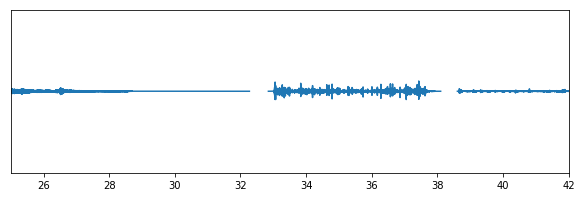

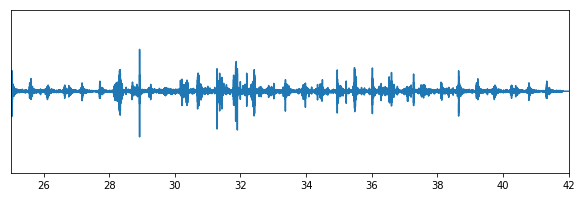

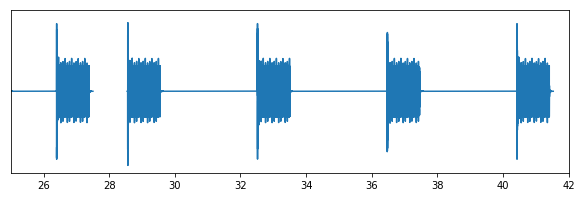

In [71]:
plot_from_array(result_distr1, 'distractor1', framerate, start_in_s=25, xlim=(25, 42), ylim=ylim, SNR_RATE=SNR_DISTRACTOR1_RATE)
plot_from_array(result_distr2, 'distractor2', framerate, start_in_s=25, xlim=(25, 42), ylim=ylim, SNR_RATE=SNR_DISTRACTOR2_RATE)
plot_from_array(result_master, 'master', framerate, start_in_s=25, xlim=(25, 42), ylim=ylim, SNR_RATE=SNR_MASTER_RATE)

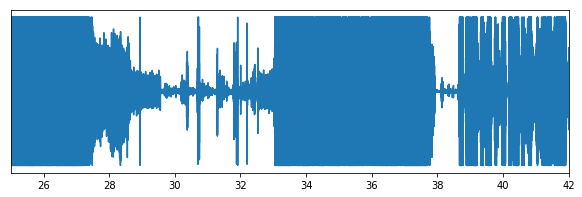

In [73]:
# mixture

fps = ['/Users/Heiner/repos/binaural_audition/common/data/data_creation/demo_sound_mixture_TelephoneElectron+6037_36_3_start25s.wav']
arrays, framerate = concat_sources(fps)

start_frames_in_source = [0]

last_frame = int(complete_mixture_length_in_s * framerate) - int(25 * framerate)

start_frames_in_result = [0]

result_mixture = merge_sources(last_frame, arrays, start_frames_in_source, start_frames_in_result)
plot_from_array(result_mixture, 'mixture', framerate, start_in_s=25, xlim=(25, 42), SNR_RATE=1)

In [61]:
abs_max = np.abs(np.nanmax([np.nanmax(result_distr1)*SNR_DISTRACTOR1_RATE, np.nanmax(result_distr2)*SNR_DISTRACTOR2_RATE, np.nanmax(result_master)*SNR_MASTER_RATE]))
abs_min = np.abs(np.nanmin([np.nanmin(result_distr1)*SNR_DISTRACTOR1_RATE, np.nanmin(result_distr2)*SNR_DISTRACTOR2_RATE, np.nanmin(result_master)*SNR_MASTER_RATE]))
maxi = np.maximum(abs_max, abs_min)
ylim = (-maxi * 1.1, maxi * 1.1)
ylim

(-0.46384429931640631, 0.46384429931640631)

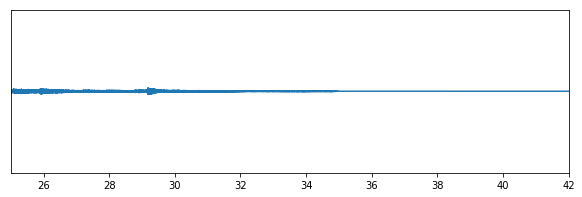

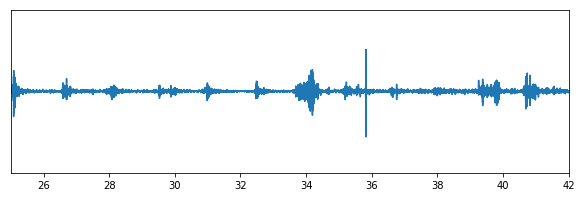

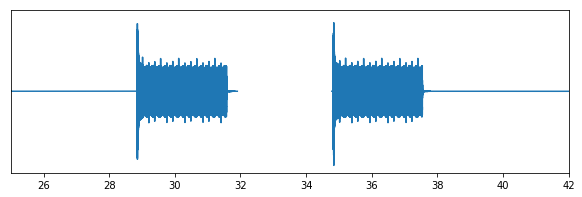

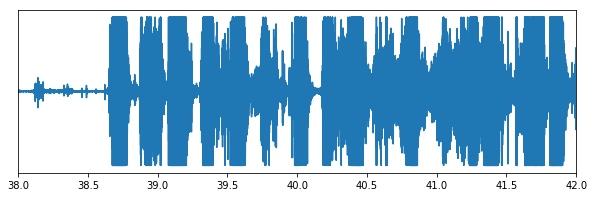

In [3]:
data = np.load('/Users/Heiner/repos/binaural_audition/common/data/data_creation/generalSoundsNI.phone.TelephoneElectron+6037_36_3.wav.mat.npz')

In [9]:
data['y'][0, 25*100:,:].shape
matched_data_part = np.repeat(data['y'][0, 25*100:,:], framerate / 100, axis=0)
matched_data = np.full((result_master.shape[0], 13), np.nan)
matched_data[:matched_data_part.shape[0], :] = matched_data_part
matched_data.shape

(752990, 13)

In [10]:
labels = ['alarm', 'baby', 'femaleSpeech',  'fire', 'crash', 'dog', 'engine', 'footsteps', 'knock', 'phone', 'piano', 'maleSpeech', 'femaleScreammaleScream']

/Users/Heiner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater_equal
  # Remove the CWD from sys.path while we load stuff.
/Users/Heiner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater_equal
  if sys.path[0] == '':


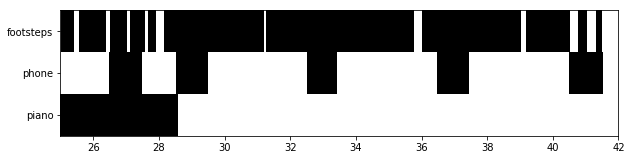

In [48]:
sparse = True


if not sparse:
    fig, ax1 = plt.subplots(1,1, figsize=(10, 10))
    plot_data = np.copy(matched_data)
    ax1.set_yticks(np.arange(0, 13))
    ax1.set_yticklabels(labels)
else:
    non_empty = np.where(np.any(matched_data>=1, axis=0))[0]
    fig, ax1 = plt.subplots(1,1, figsize=(10, (10/13)*len(non_empty)))
    non_empty = np.where(np.any(matched_data>=1, axis=0))[0]
    plot_data = np.copy(matched_data)
    plot_data = plot_data[:, non_empty]
    ax1.set_yticks(np.arange(0, len(non_empty)))
    ax1.set_yticklabels([labels[index] for index in non_empty])
    
ax1.imshow(plot_data.T, cmap='Greys', aspect='auto')
x = np.arange(framerate, matched_data.shape[0], 2*framerate)
x_labels = np.arange(26, 44, 2)
ax1.set_xticks(x)
ax1.set_xticklabels(x_labels)
xlim=((25-25), (42-25)*framerate)
ax1.set_xlim(xlim)
plt.show()

In [ ]:
# distr 1: piano, general, general
# distr 2: footsteps
# master: phone

In [27]:
labels = ['alarm', 'baby', 'femaleSpeech',  'fire', 'crash', 'dog', 'engine', 'footsteps', 'knock', 'phone', 'piano', 'maleSpeech', 'femaleScreammaleScream']

In [23]:
result_master.shape[0]

752990

In [ ]:
# framerate pro sekunden
# framerate / 1000 pro millisekunde
# framerate / 100 pro 10 millisekunde